<a href="https://colab.research.google.com/github/Touransland-ZC/Technical__Assignment/blob/main/FileOrganizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git config --global user.name "Touransland-ZC"
!git config --global user.email "s-touransland.saleh@zewailcity.edu.eg"

# **File organizer**

This is a script that organizes files in a given folder by file type, such as images, documents, videos, archives, code, eBooks. any other file will be categoriezed as others.



**Folder source:** The input folder can be either from google drive (the changes will take place in the real folder), or it can write a folder uploaded to the Colab environment (This is because Colab is considered VM, so it can't edit the real PC files)




**Simulation mode**
The user can run a simulation mode, which will show what will happen without moving the files.

**Summary:** Three summaries are provided. The first one indicates the movement of each file name to its distenation, the second one indicates the total number of files under each category. The third one is a pie chart, and it is based on the user's request.

In [18]:
%%writefile file_organizer.py

import argparse
from pathlib import Path
import shutil
import matplotlib.pyplot as plt


# myExtensions_Groups is a dict, each key represents a category which will map to a tuble representing the most popular extensions
# these are the most popular extensions, any new ext will be categorized as 'others' later
myExtensions_Groups = {
    "Images": ("jpg", "jpeg", "png", "gif", "bmp", "tiff", "tif", "webp", "svg", "heic", "heif", "ico",),

    "Documents": ("pdf", "doc", "docx", "xls", "xlsx", "ppt", "pptx","txt", "md", "rtf", "csv", "tsv", "json","xml", "yaml", "yml", "ipynb", "tex",),

    "Videos": ("mp4", "mkv", "mov", "avi", "wmv", "flv", "webm", "m4v","3gp", "mpeg", "mpg", "ts", "m2ts", "ogv",),

    "Audio": ("mp3", "wav", "flac", "aac", "m4a", "ogg", "opus", "wma","aiff", "aif", "mid", "midi", "amr", "caf",),

    "Archives": ("zip", "rar", "7z", "tar", "gz", "bz2", "xz", "zst", "lz", "lzma","tgz", "tbz2", "txz",),

    "Code": ("py", "js", "ts", "jsx", "tsx","html", "css","c", "h", "cpp", "hpp", "cc", "cs", "java", "kt", "go", "rs", "rb", "php", "r", "jl", "m","sh", "bash", "zsh", "ps1", "bat", "pl", "lua", "sql","v", "sv", "vhd", "vhdl",),

    "eBooks": ("epub", "mobi", "azw", "azw3", "djvu", "fb2",),}




# flattening myExtensions_Groups to make the maping faster O(1)
EXT_TO_CATEGORY = {}
for cat, exts in myExtensions_Groups.items():
    for ext in exts:
        EXT_TO_CATEGORY[ext] = cat



# all the categories names, I will use this fixed order for a summary for the users
CATEGORIES = tuple([*myExtensions_Groups.keys(), "Others"])




# choose the file category based on the last file extension, and for unknown ext categorise them as 'Others'
def categorize(path: Path) -> str:
    ext = path.suffix.lower().lstrip(".")
    return EXT_TO_CATEGORY.get(ext, "Others")




# avoid overwriting existing files, so if a file name exists in its category folder, maybe from a previous run, then give it the same name but with a number.
# this happens in our real life, for ex when we past a file twice in folder, we find the new version's name have number between brackets like aaa.pdf, aaa (1).pdf, and so on.
# it handles if the file has multi suffix, like (archive.tar.gz)
# it handles the hidden files and the files with no extensions like the Readme
def safe_destination(dst_dir: Path, name: str) -> Path:
    p = Path(name)
    file_extensions = "".join(p.suffixes)

    if file_extensions:
        cut_extensions = len(p.name) - len(file_extensions)
        file_base_name = p.name[:cut_extensions]
    else:
        file_base_name = p.name

    new_file_path = dst_dir / (file_base_name + file_extensions)
    n = 1

    while new_file_path.exists():
        new_file_path = dst_dir / f"{file_base_name} ({n}){file_extensions}"
        n += 1
    return new_file_path





# scans the folder, without recursions or scannign subfolders
def scan_top_level(root: Path):
    for i in root.iterdir():
        if i.is_file():
            yield i




# it makes like a to-do list of the moves without moving the files
# it returns a list of tubles having the file source, distenation and category for moves
def plan_moves(root: Path):
    moves = []
    for f_src in scan_top_level(root):
        if not f_src.is_file():
            continue
        f_category = categorize(f_src)
        f_dst = safe_destination(root / f_category, f_src.name)
        moves.append((f_src, f_dst, f_category))
    return moves




# it can either executes or simulates the moves based on plan_moves.
# it returns counts per category.
def apply_moves(moves, simulate: bool = False):

    counts = {i_catergory: 0 for i_catergory in CATEGORIES}

    for f_src, f_dst, f_category in moves:

        if simulate:
            counts[f_category] += 1
            continue

        print(f"MOVE {f_src.name} -> {f_category}/{f_dst.name}")   # print each move
        try:
            f_dst.parent.mkdir(parents=True, exist_ok=True)
            shutil.move(str(f_src), str(f_dst))                     # moving
            counts[f_category] += 1
        except Exception as e:
            print(f"SKIP {f_src.name} -> {f_category}/{f_dst.name} [error: {e}]")

    return counts




# printing a summary of the number of files moved per category.
def print_summary(counts):
    total = sum(counts.values())
    print("\n-.-_.-._-.-_.-._.-._.-.-\n\tSummary\n-.-_.-._-.-_.-._.-._.-.-")

    for i in CATEGORIES:
        print(f"{i}: {counts.get(i, 0)}")
    print(f"Total: {total}")




# it shows the summary in a form of a pie chart, if there was no files in the folder then it will say No files to plot
def show_summary_pie(counts, title="Files per category"):
    labels = [c for c in CATEGORIES if counts.get(c, 0)]
    sizes  = [counts[c] for c in labels]

    if not sizes:
        print("No files to plot")
        return
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct="%d", startangle=90)
    ax.axis("equal")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()







# the command line interface.
# the user will have an aoption to simulation mode
def parse_args(argv=None):
    p = argparse.ArgumentParser(description="Organize files in a folder into Images, Documents, Videos, Audio, Archives, eBooks, Others based on extension.")

    p.add_argument("folder", type=Path, help="Path to the folder to organize")
    p.add_argument("--simulate", action="store_true", help="Show what would happen without moving files")
    p.add_argument("--plot-pie", action="store_true", help="Show a pie chart of the counts")

    return p.parse_args(argv)





def main(argv=None) -> int:
    args = parse_args(argv)
    root = args.folder

    if not root.exists() or not root.is_dir():
        print("The path must be an existing directory")
        return 2

    moves = plan_moves(root)
    counts = apply_moves(moves, simulate=args.simulate)

    print_summary(counts)

    if getattr(args, "plot_pie", False):
        show_summary_pie(counts)



    return 0



if __name__ == "__main__":
    raise SystemExit(main())


Overwriting file_organizer.py


# **The runner for Colab**

Choose source
  1) Google Drive folder
  2) Existing folder under /content 
Enter a number: 1
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive folder path: /content/drive/MyDrive/Testing_drive_folder
Simulate only [1=Yes, 2=No] 2
Show pie chart now [1=Yes, 2=No] 1
MOVE i.pptx -> Documents/i (1).pptx
MOVE a.zip -> Archives/a (1).zip
MOVE f.docx -> Documents/f (1).docx
MOVE d.docx -> Documents/d (1).docx
MOVE k.xlsx -> Documents/k (1).xlsx
MOVE j.txt -> Documents/j (1).txt
MOVE c.bmp -> Images/c (1).bmp
MOVE b.accdb -> Others/b (1).accdb

-.-_.-._-.-_.-._.-._.-.-
	Summary
-.-_.-._-.-_.-._.-._.-.-
Images: 1
Documents: 5
Videos: 0
Audio: 0
Archives: 1
Code: 0
eBooks: 0
Others: 1
Total: 8


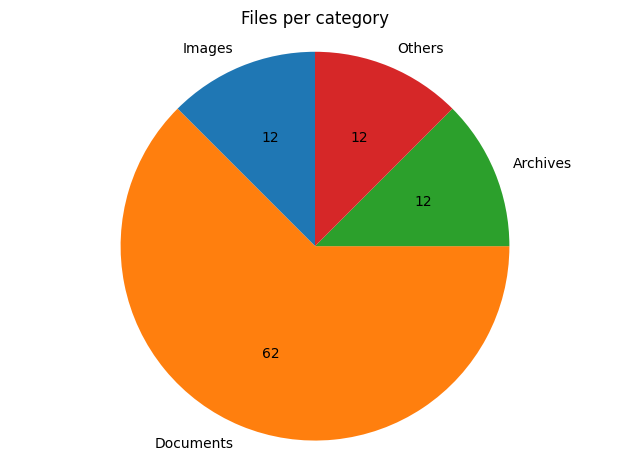

In [ ]:
from pathlib import Path
import importlib
import file_organizer as org




# thses is the allowed roots for safety and clearer error messages
# Note: I am working on Colab, so I am using the Colab VM storage not the actual pc stoage
# also the user can choose to organize a folder from the drive
ALLOWED_CONTENT = (Path("/content"),)
ALLOWED_DRIVE   = (Path("/content/drive"),)




# Simple menu loop to ask the user whether the folder is on the drive or was uploaded earlier on Colab VM storage
# the user must enters a valide number that represents the choice
def pick(prompt, choices):
    while True:
        print(prompt)
        for k, v in choices.items():
            print(f"  {k}) {v}")
        ans = input("Enter a number: ").strip()
        if ans in choices:
            return ans
        print("Invalid choice.\n")




# Yes/No prompt, the default is true
def my_yn_fun(prompt, default=True):
    ans = input(f"{prompt} [1=Yes, 2=No] ").strip()
    return default if ans == "" else ans == "1"




# Ask for a folder path until it’s valid.
# there is some checkings like being under one of the allowed roots, and must be a directory, it returns the default when empty
def prompt_dir_until_valid(title, default=None, must_under=(), require_non_empty=True):
    while True:
        suffix = f" [{default}]" if default else ""
        raw = input(f"{title}{suffix}: ").strip()
        if raw == "" and default:
            raw = default
        p = Path(raw)

        if must_under and not any(str(p).startswith(str(root)) for root in must_under):
            roots = " or ".join(str(r) for r in must_under)
            print(f"Path must start with {roots}\n")
            continue
        if not p.exists():
            print("Path not found\n")
            continue
        if not p.is_dir():
            print("Path is not a directory\n")
            continue
        if require_non_empty and not any(p.iterdir()):
            print("Folder is empty\n")
            continue
        return p




# the main interaction loop
def run():
    importlib.reload(org) # reloading so the edits be effective

    while True:  # asking each time for the source whether it is from the drive or was uploaded on the virtual machine strorage of Colab
        src = pick("Choose source", { "1": "Google Drive folder", "2": "Existing folder under /content ",})

        if src == "1":
            from google.colab import drive
            drive.mount("/content/drive")
            folder = prompt_dir_until_valid("Drive folder path", must_under=ALLOWED_DRIVE, require_non_empty=True,)

        else:
            folder = prompt_dir_until_valid(
                "Folder under /content (e.g., /content/inbox)", default="/content/inbox", must_under=ALLOWED_CONTENT, require_non_empty=True,)

        simulate = my_yn_fun("Simulate only", True)    # simulation mode, without moving
        show_pie = my_yn_fun("Show pie chart now", True)

        argv = [str(folder)]
        if simulate: argv.append("--simulate")
        if show_pie: argv.append("--plot-pie")

        org.main(argv)

        if not my_yn_fun("Organize another folder", False):
            break

run()


# **Testing coverage**

In [10]:
# Run once
'''
import os
os.makedirs("tests", exist_ok=True)
os.makedirs(".github/workflows", exist_ok=True)
'''

In [11]:
%%writefile tests/conftest.py
import matplotlib.pyplot as plt
import pytest

@pytest.fixture(autouse=True)
def _no_blocking_show(monkeypatch):
    monkeypatch.setattr(plt, "show", lambda *a, **k: None)

@pytest.fixture
def make_files(tmp_path):
    def _mk(mapping):
        for name, content in mapping.items():
            p = tmp_path / name
            p.write_text(content)
        return tmp_path
    return _mk


Writing tests/conftest.py


In [12]:
%%writefile tests/test_file_organizer.py
from pathlib import Path
import file_organizer as org

def test_categorize_known_and_unknown(tmp_path):
    img = tmp_path / "a.JPG"
    txt = tmp_path / "b.txt"
    binf = tmp_path / "program.bin"
    img.write_text("x"); txt.write_text("x"); binf.write_bytes(b"\x00\x01")
    assert org.categorize(img) == "Images"
    assert org.categorize(txt) == "Documents"
    assert org.categorize(binf) == "Others"

def test_safe_destination_handles_duplicates_and_extensions(tmp_path):
    dst = tmp_path / "Images"; dst.mkdir()
    (dst / "photo.png").write_text("old")
    (dst / "archive.tar.gz").write_text("old")
    p1 = org.safe_destination(dst, "photo.png")
    p2 = org.safe_destination(dst, "archive.tar.gz")
    p3 = org.safe_destination(dst, ".gitignore")
    p4 = org.safe_destination(dst, "README")
    assert p1.name == "photo (1).png"
    assert p2.name == "archive (1).tar.gz"
    assert p3.name == ".gitignore"
    assert p4.name == "README"

def test_scan_top_level_skips_dirs(tmp_path):
    (tmp_path / "f1.txt").write_text("x")
    sub = tmp_path / "sub"; sub.mkdir()
    (sub / "nested.txt").write_text("y")
    names = {p.name for p in org.scan_top_level(tmp_path)}
    assert names == {"f1.txt"}

def test_plan_moves_uses_category_and_safe_destination(tmp_path):
    (tmp_path / "a.png").write_text("x")
    (tmp_path / "b.pdf").write_text("x")
    d = tmp_path / "Images"; d.mkdir()
    (d / "a.png").write_text("old")
    moves = org.plan_moves(tmp_path)
    trio = sorted([(src.name, dst.parent.name, dst.name) for src, dst, _ in moves])
    assert trio == [("a.png", "Images", "a (1).png"), ("b.pdf", "Documents", "b.pdf")]

def test_apply_moves_simulate_counts_only(tmp_path):
    (tmp_path / "a.mp4").write_text("x")
    (tmp_path / "b.xyz").write_text("x")
    moves = org.plan_moves(tmp_path)
    counts = org.apply_moves(moves, simulate=True)
    assert counts["Videos"] == 1
    assert counts["Others"] == 1
    assert (tmp_path / "a.mp4").exists()
    assert (tmp_path / "b.xyz").exists()

def test_apply_moves_real(tmp_path):
    (tmp_path / "a.mp3").write_text("x")
    moves = org.plan_moves(tmp_path)
    counts = org.apply_moves(moves, simulate=False)
    assert counts["Audio"] == 1
    assert not (tmp_path / "a.mp3").exists()
    assert (tmp_path / "Audio" / "a.mp3").exists()

def test_print_summary_output(capsys):
    counts = {c: 0 for c in org.CATEGORIES}
    counts["Images"] = 2; counts["Others"] = 1
    org.print_summary(counts)
    out = capsys.readouterr().out
    assert "Images: 2" in out
    assert "Others: 1" in out
    assert "Total: 3" in out

def test_show_summary_pie_handles_empty_counts(capsys):
    counts = {c: 0 for c in org.CATEGORIES}
    org.show_summary_pie(counts)
    out = capsys.readouterr().out
    assert "No files to plot" in out

def test_parse_args_flags():
    args = org.parse_args([str(Path(".")), "--simulate", "--plot-pie"])
    assert args.simulate is True
    assert args.plot_pie is True

def test_main_invalid_path_returns_2(tmp_path, capsys):
    missing = tmp_path / "nope"
    rc = org.main([str(missing)])
    assert rc == 2
    assert "must be an existing directory" in capsys.readouterr().out

def test_main_simulate_does_not_move(tmp_path):
    f = tmp_path / "doc.txt"; f.write_text("x")
    rc = org.main([str(tmp_path), "--simulate"])
    assert rc == 0
    assert f.exists()


Writing tests/test_file_organizer.py


In [13]:
%%writefile requirements.txt
pytest
pytest-cov
matplotlib


Overwriting requirements.txt


In [14]:
%%writefile .github/workflows/ci.yml
name: tests
on:
  push:
  pull_request:
jobs:
  test:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v4
      - uses: actions/setup-python@v5
        with:
          python-version: '3.11'
          cache: 'pip'
      - run: pip install -r requirements.txt
      - run: pytest -q --cov=file_organizer --cov-report=term-missing --junitxml=report.xml
      - uses: actions/upload-artifact@v4
        with:
          name: pytest-artifacts
          path: report.xml


Writing .github/workflows/ci.yml


In [23]:
%%writefile tests/test_file_organizer_more.py
import shutil
from pathlib import Path
import builtins
import file_organizer as org

def test_show_summary_pie_non_empty(monkeypatch):
    # Avoid real GUI
    import matplotlib.pyplot as plt
    called = {"show": 0, "pie": 0}
    monkeypatch.setattr(plt, "show", lambda *a, **k: called.__setitem__("show", called["show"] + 1))
    def wrap_pie(*a, **k):
        called["pie"] += 1
        return plt.pie.__wrapped__(*a, **k) if hasattr(plt.pie, "__wrapped__") else None
    # if Matplotlib can't wrap like this on your runtime, it's fine:
    # the next line just ensures pie got called at least once.
    try:
        monkeypatch.setattr(plt, "pie", wrap_pie)
    except Exception:
        pass

    counts = {c: 0 for c in org.CATEGORIES}
    counts["Images"] = 2
    counts["Documents"] = 1
    org.show_summary_pie(counts, title="t")

    # show must be invoked
    assert called["show"] >= 1

def test_safe_destination_numbering_to_two(tmp_path):
    dst = tmp_path / "Documents"
    dst.mkdir()
    # Existing base and “(1)” to force “(2)”.
    (dst / "file.txt").write_text("x")
    (dst / "file (1).txt").write_text("x")
    p = org.safe_destination(dst, "file.txt")
    assert p.name == "file (2).txt"

def test_apply_moves_handles_exception(tmp_path, monkeypatch, capsys):
    # Prepare a file that should be moved
    f = tmp_path / "x.pdf"
    f.write_text("x")
    moves = org.plan_moves(tmp_path)

    # Force shutil.move to raise
    def boom(*a, **k):
        raise OSError("disk full")
    monkeypatch.setattr(shutil, "move", boom)

    counts = org.apply_moves(moves, simulate=False)
    out = capsys.readouterr().out

    # No count increment, file still exists, and SKIP message is printed
    assert counts["Documents"] == 0
    assert f.exists()
    assert "SKIP x.pdf -> Documents" in out

def test_main_with_plot_and_simulate(tmp_path, monkeypatch):
    # One file so counts are non-empty; also trigger --plot-pie branch
    (tmp_path / "v.mkv").write_text("x")
    # Stub plt.show to avoid blocking
    import matplotlib.pyplot as plt
    monkeypatch.setattr(plt, "show", lambda *a, **k: None)

    rc = org.main([str(tmp_path), "--simulate", "--plot-pie"])
    assert rc == 0


Writing tests/test_file_organizer_more.py


In [25]:
%%writefile tests/test_file_organizer_more_more.py
import subprocess, sys
import file_organizer as org

def test_apply_moves_real_print(capsys, tmp_path):
    f = tmp_path / "doc.txt"
    f.write_text("hello")
    moves = org.plan_moves(tmp_path)
    counts = org.apply_moves(moves, simulate=False)
    out = capsys.readouterr().out
    assert "MOVE doc.txt -> Documents/doc.txt" in out
    assert counts["Documents"] == 1

def test_run_as_script(tmp_path):
    f = tmp_path / "a.txt"
    f.write_text("content")
    result = subprocess.run(
        [sys.executable, "file_organizer.py", str(tmp_path), "--simulate"],
        capture_output=True,
        text=True
    )
    assert result.returncode == 0
    assert "Summary" in result.stdout


Writing tests/test_file_organizer_more_more.py


In [27]:
%%writefile tests/test_file_organizer_last.py
import file_organizer as org

def test_apply_moves_hits_line_91(capsys, tmp_path):
    # Create a file so apply_moves runs the normal MOVE branch
    f = tmp_path / "doc.txt"
    f.write_text("hello")
    moves = org.plan_moves(tmp_path)

    # Run in non-simulate mode so the MOVE print executes
    counts = org.apply_moves(moves, simulate=False)
    out = capsys.readouterr().out

    # Assert the MOVE line is in output
    assert "MOVE doc.txt -> Documents/doc.txt" in out
    assert counts["Documents"] == 1


Writing tests/test_file_organizer_last.py


# **Running the test coverage**

In [21]:
%env PYTHONPATH=/content

env: PYTHONPATH=/content


In [29]:
!pip -q install -r requirements.txt
!pytest -q --cov=file_organizer --cov-report=term-missing


..................                                                       [100%]
================================ tests coverage ================================
_______________ coverage: platform linux, python 3.11.13-final-0 _______________

Name                Stmts   Miss  Cover   Missing
-------------------------------------------------
file_organizer.py      91      1    99%   91
-------------------------------------------------
TOTAL                  91      1    99%
18 passed in 18.85s
